# Generating new instances for the Zalando Fashion MNIST

In [1]:
%matplotlib inline

import keras
from keras.datasets import fashion_mnist
import numpy as np

from matplotlib import pyplot
from matplotlib.pyplot import imshow

Using TensorFlow backend.


In [2]:
# https://github.com/zalandoresearch/fashion-mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

('x_train shape:', (60000, 28, 28))
(60000, 'train samples')
(10000, 'test samples')


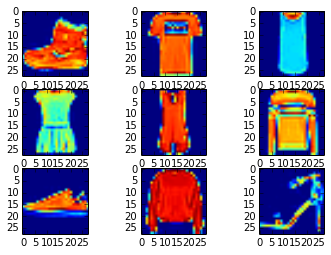

In [3]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
image_size = x_train.shape[1]

for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    imshow(x_train[i])
    imgplot = pyplot.imshow(x_train[i])

In [4]:
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [5]:
print y_train.shape
print y_test.shape

(60000,)
(10000,)


Normalize inputs to change their range from [0, 255] to [0, 1].

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

Convert the input matrix from grayscale (image_size, image_size) to single channel (image_size, image_size, 1)

In [7]:
x_train_ = np.reshape(x_train, (len(x_train), image_size, image_size, 1))
print "Reshaped train to", x_train_.shape

x_test_ = np.reshape(x_test, (len(x_test), image_size, image_size, 1))
print "Reshaped test to", x_test_.shape

Reshaped train to (60000, 28, 28, 1)
Reshaped test to (10000, 28, 28, 1)


In [8]:
input_shape = x_train_.shape[1:]
print input_shape

(28, 28, 1)


## Implementing a discriminator based on a DCNN

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose
from keras.optimizers import SGD, rmsprop, Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [14]:
discriminator = Sequential()
# stage 1
print "Creating net with input", x_train.shape[1:]
discriminator.add(Conv2D(32, (3, 3), input_shape=x_train_.shape[1:], activation='relu', padding='same'))
discriminator.add(Dropout(0.6))
# stage 2
discriminator.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.4))
# stage 3
discriminator.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.25))
# stage 4
discriminator.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.25))
# stage 5
discriminator.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Flatten())
discriminator.add(Dropout(0.25))
# stage 6
discriminator.add(Dense(1024, activation='relu'))
discriminator.add(Dropout(0.25))
# stage 7
discriminator.add(Dense(512, activation='relu'))
discriminator.add(Dropout(0.25))
# stage 8
# instead of the softmax we would use for classification we use sigmoid
#discriminator.add(Dense(num_classes, activation='softmax'))
discriminator.add(Dense(1, activation='sigmoid'))

Creating net with input (28, 28)


In [15]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [16]:
#optimizer = rmsprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss="binary_crossentropy",
                      optimizer=optimizer,
                      # optimizer = "adam",
                      metrics=["accuracy"])

## Implementing the Generator

In [17]:
generator = Sequential()
input_noise_size = 100
initial_generator_depth = 256
dim = 7
# dim is 7 as we double it progressively to 14 and then 28 over the stages
# as in https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

# stage 1 -> (dim, dim, depth)
generator.add(Dense(dim*dim*initial_generator_depth, 
                    input_dim=input_noise_size))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))
# https://github.com/keras-team/keras/issues/4534
generator.add(Reshape( (dim, dim, initial_generator_depth) ))
generator.add(Dropout(0.4))

# stage 2 -> (2dim, 2dim, depth/2)
# de-convolution: conv2dtranspose
# https://keras.io/layers/convolutional/#conv2dtranspose
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(initial_generator_depth/2, 
                              5, # kernel_size
                              padding="same"))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))

# stage 3 -> (4dim, 4dim, depth/4)
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(initial_generator_depth/4, 
                              5, # kernel_size
                              padding="same"))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))

# stage 4 ->
generator.add(Conv2DTranspose(1, 
                              5, # kernel_size
                              padding="same"))
generator.add(Activation("sigmoid"))

In [18]:
print generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
__________

## Implementing the GAN

In [19]:
#optimizer = rmsprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
optimizer = Adam(lr=0.0002, beta_1=0.5)

gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

## Training the discriminator

### Creating fake dataset instances

In [20]:
# generate random noise (of equal size compared to real data) and use the generator to create fake images
noise_train = np.random.uniform(-1.0, 1.0, size=[x_train_.shape[0], 100])
noise_test = np.random.uniform(-1.0, 1.0, size=[x_test_.shape[0], 100])

print "noise train", noise_train.shape
print "noise test", noise_test.shape

train_images_fake = generator.predict(noise_train)
test_images_fake = generator.predict(noise_test)

print "fake train images", train_images_fake.shape
print "fake test images", test_images_fake.shape

noise train (60000, 100)
noise test (10000, 100)
fake train images (60000, 28, 28, 1)
fake test images (10000, 28, 28, 1)


In [21]:
x_test_.shape[0]

10000

In [22]:
d_train_x = np.concatenate( (x_train_, train_images_fake) )
print d_train_x.shape

d_test_x = np.concatenate( (x_test_, test_images_fake) )
print d_test_x.shape

(120000, 28, 28, 1)
(20000, 28, 28, 1)


In [23]:
# create a 2*train array initially set to 1
d_train_y = np.ones([2*x_train_.shape[0], 1])
# set the second half (fake images) to 0
d_train_y[x_train_.shape[0]:, :] = 0

In [24]:
# create a 2*test array initially set to 1
d_test_y = np.ones([2*x_test_.shape[0], 1])
# set the second half (fake images) to 0
d_test_y[x_test_.shape[0]:, :] = 0

### Train the Discriminator

In [25]:
from keras.preprocessing.image import ImageDataGenerator

def get_img_generator():
    return ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

In [26]:
seed = 1234

In [27]:
np.random.seed(seed)

epochs = 1
batch_size= 64

datagen = get_img_generator()
discriminator.fit_generator(datagen.flow(d_train_x, d_train_y, batch_size=batch_size),
                    epochs=epochs,
                    shuffle=True,
                    validation_data=(d_test_x, d_test_y),
                    workers=6)

Epoch 1/1
1875/1875 [==============================] - 307s 163ms/step - loss: 0.0192 - acc: 0.9916 - val_loss: 0.0013 - val_acc: 1.0000


### Assess the discriminator performance using the test data

In [28]:
scores = discriminator.evaluate(d_test_x, d_test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 100.00%


## Training the Generator

### Create a test dataset for the GA

In [29]:
np.random.seed(seed)
# get an array of random samples to be used to test the GAN at the end of the training
test_size = 16
test_noise = np.random.uniform(-1.0, 1.0, size=[test_size, 100])

### Train the GA using random input noise

0: [Discriminator loss: 0.000007, acc: 1.000000]


/Library/Python/2.7/site-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [GA loss: 9.992092, acc: 0.000000]
1: [Discriminator loss: 0.005050, acc: 0.998047]
1: [GA loss: 0.109980, acc: 0.957031]
2: [Discriminator loss: 0.208171, acc: 0.925781]
2: [GA loss: 8.928638, acc: 0.003906]
3: [Discriminator loss: 0.038625, acc: 0.992188]
3: [GA loss: 6.920877, acc: 0.050781]
4: [Discriminator loss: 0.073268, acc: 0.984375]
4: [GA loss: 0.287348, acc: 0.890625]
5: [Discriminator loss: 0.124786, acc: 0.982422]
5: [GA loss: 0.000500, acc: 1.000000]
6: [Discriminator loss: 0.049751, acc: 0.976562]
6: [GA loss: 0.001371, acc: 1.000000]
7: [Discriminator loss: 0.170196, acc: 0.949219]
7: [GA loss: 2.275584, acc: 0.429688]
8: [Discriminator loss: 0.235861, acc: 0.945312]
8: [GA loss: 0.167863, acc: 0.941406]
9: [Discriminator loss: 1.788023, acc: 0.580078]
9: [GA loss: 15.804901, acc: 0.000000]
10: [Discriminator loss: 4.938532, acc: 0.541016]
10: [GA loss: 8.288842, acc: 0.000000]
11: [Discriminator loss: 1.778264, acc: 0.625000]
11: [GA loss: 1.525816, acc: 0.000000]


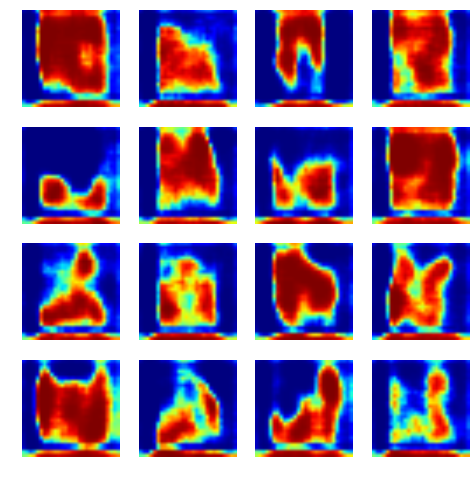

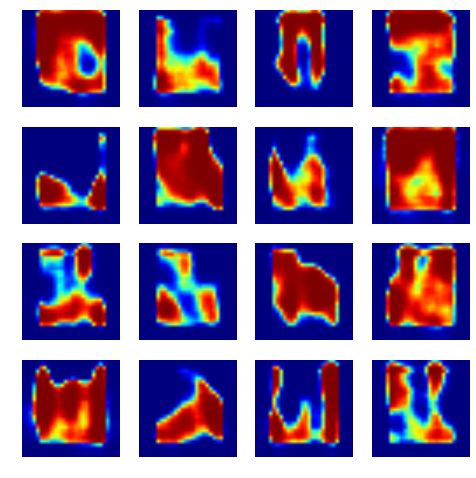

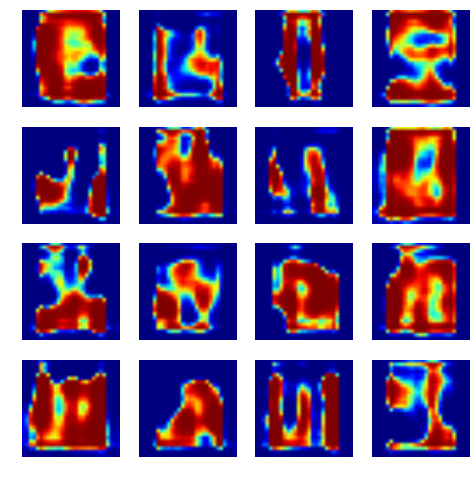

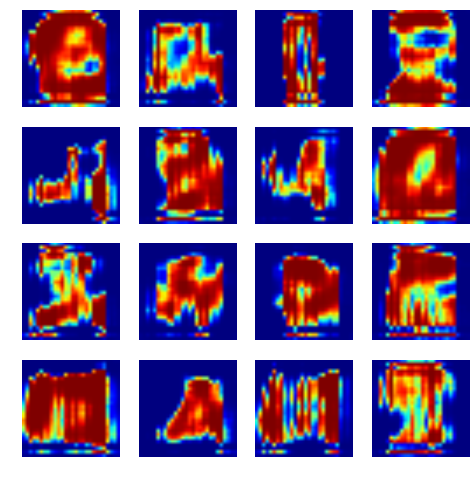

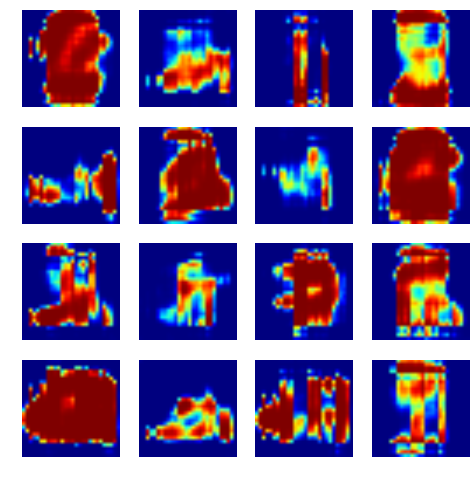

In [30]:
np.random.seed(seed)

epochs = 500
batch_size = 256
plot_interval = 100

retrain_discriminator = True

def plot_img(i_w, synthetic_images, i, j):
    pyplot.figure(figsize=(i_w, i_w))
    for im in range( synthetic_images.shape[0] ):
        pyplot.subplot(4, 4, im+1)
        synthetic_image = np.reshape(synthetic_images[im, :, :, :], [i, j])
        pyplot.imshow(synthetic_image)
        pyplot.axis("off")

from tqdm import tqdm
for e in tqdm(range(epochs)):
    # stage 1: train the discriminator
    if retrain_discriminator:    
        # select batch_size entries from the train set
        x_train__ = x_train_[np.random.randint(0, x_train_.shape[0], size=batch_size), :, :, :]
        # generate fake instances from random noise
        d_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        images_fake = generator.predict(d_noise)
        d_x = np.concatenate((x_train__, images_fake))
        # create a 2*batch_size array initially set to 1
        d_y = np.ones([2*batch_size, 1])
        # set the second half (fake images) to 0
        d_y[batch_size:, :] = 0
        # train the discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(d_x, d_y)
        print "%d: [Discriminator loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
    
    # stage 2: train the generator-discriminator as adversarial
    input_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    gan_y = np.ones([batch_size, 1])
    discriminator.trainable = False
    ga_loss = gan.train_on_batch(input_noise, gan_y)
    print "%d: [GA loss: %f, acc: %f]" % (e, ga_loss[0], ga_loss[1])
    
    # plot after plot_interval epochs
    if (e+1)%plot_interval == 0:            
        # plot the output images from the test noise
        synthetic_images = generator.predict(test_noise)
        i_w = test_size / 2
        plot_img(i_w, synthetic_images, x_train_.shape[1], x_train_.shape[2])